<a href="https://colab.research.google.com/github/lauranorenab/Proyecto_Modelos_2/blob/main/Preprocesamiento_Car_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
import os
from google.colab import files
import scipy.io
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import plotly.express as px
import tkinter
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from collections import Counter

%matplotlib inline
sns.set(color_codes=True)

En el preprocesamiento del modelo para la evaluación de vehículos, no se llevó a cabo ningún procedimiento de tratamiento de datos atípicos, nulos o duplicados. Esta decisión se tomó ya que en los resultados obtenidos durante el Análisis Exploratorio de Datos (EDA), se determinó que no existían instancias de estas problemáticas en el conjunto de datos.

## Lectura del dataset

In [6]:
!pip install ucimlrepo

In [7]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
car_evaluation = fetch_ucirepo(id=19)

# data (as pandas dataframes)
X_car = car_evaluation.data.features
y_car = car_evaluation.data.targets

In [8]:
df_car = pd.concat([X_car, y_car], axis=1)

## Label Encoding

Esta técnica se utiliza para transformar las etiquetas de texto en valores numéricos ya que en este caso, se requiere que las variables categóricas sean de tipo numérico. Esto se debe hacer porque muchos algoritmos solo aceptan entradas numéricas.

Se tranforman las columnas de entrada usando lable encoding

In [9]:
df_car_categoric_columns = list(X_car.columns)
print(df_car_categoric_columns)

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']


In [10]:
from sklearn.preprocessing import LabelEncoder

from collections import defaultdict
x_car_label = car_evaluation.data.features

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

X_car = MultiColumnLabelEncoder(columns = df_car_categoric_columns).fit_transform(x_car_label)


In [11]:
X_car

,buying,maint,doors,persons,lug_boot,safety
0,3,3,0,0,2,1
1,3,3,0,0,2,2
2,3,3,0,0,2,0
3,3,3,0,0,1,1
4,3,3,0,0,1,2
...,...,...,...,...,...,...
1723,1,1,3,2,1,2
1724,1,1,3,2,1,0
1725,1,1,3,2,0,1
1726,1,1,3,2,0,2


In [12]:
y_car['class'].astype('category')
y_car['class'].unique()

array(['unacc', 'acc', 'vgood', 'good'], dtype=object)

In [13]:
df_car = pd.concat([X_car, y_car], axis=1)
df_car

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,0,0,2,1,unacc
1,3,3,0,0,2,2,unacc
2,3,3,0,0,2,0,unacc
3,3,3,0,0,1,1,unacc
4,3,3,0,0,1,2,unacc
...,...,...,...,...,...,...,...
1723,1,1,3,2,1,2,good
1724,1,1,3,2,1,0,vgood
1725,1,1,3,2,0,1,unacc
1726,1,1,3,2,0,2,good


## Balanceo de clases


El balanceo se utiliza cuando existe una disparidad significativa en la cantidad de ejemplos para cada clase en un conjunto de datos dado. En este apartado se está aplicando diferentes métodos de balanceo para probar cual tiene mejores resultados.

En este caso, se escogieron los métodos:
- **SMOTE**: es una técnica de sobremuestreo, donde se agregan nuevos datos basados en los ejemplos existentes.


In [14]:
def mostrarGrafica(y):
    # Crear un diccionario con las etiquetas de clase y el número de muestras por clase
    dicto = dict(zip(np.unique(y, return_counts=True)[0], np.unique(y, return_counts=True)[1]))

    # Definir colores distintos para cada barra
    colores = plt.cm.tab10(np.linspace(0, 1, len(dicto)))

    # Crear la figura y los ejes
    fig, ax = plt.subplots()

    # Generar las barras con colores distintos
    for i, (clase, muestras) in enumerate(dicto.items()):
        ax.bar(clase, muestras, color=colores[i])

    # Configurar título y etiquetas de los ejes
    ax.set_title("Número de muestras por clase")
    ax.set_xlabel("etiqueta de la clase")
    ax.set_ylabel("# muestras por clase")
    ax.set_xticks(list(dicto.keys()))

    # Ocultar los bordes superior y derecho del gráfico
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

**En la siguiente gráfica se observa la existencia de un desbalance considerable:**

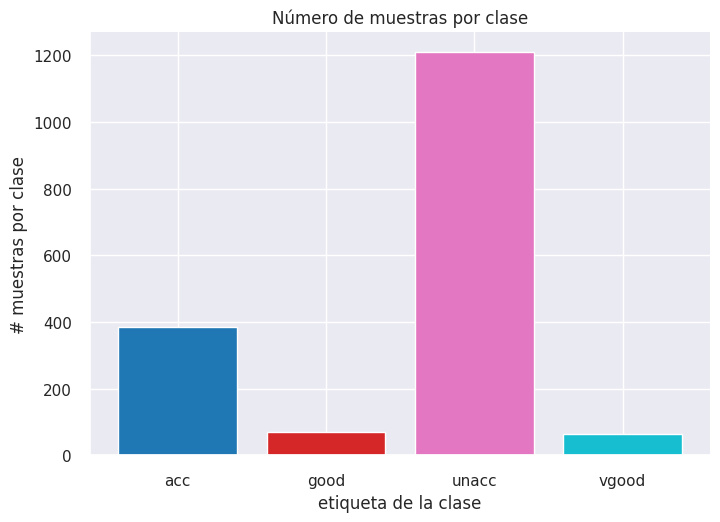

In [15]:
mostrarGrafica(y_car)

In [16]:
sm = SMOTE(
    sampling_strategy='auto',
    random_state=0,
    k_neighbors=5,
)
X_car_smote, y_car_smote = sm.fit_resample(X_car, y_car)

**Por este lado, se puede observar la distribución de las clases una vez se aplicó la técnica de sobremuestreo SMOTE, donde el desbalanceo desapareció totalmente:**

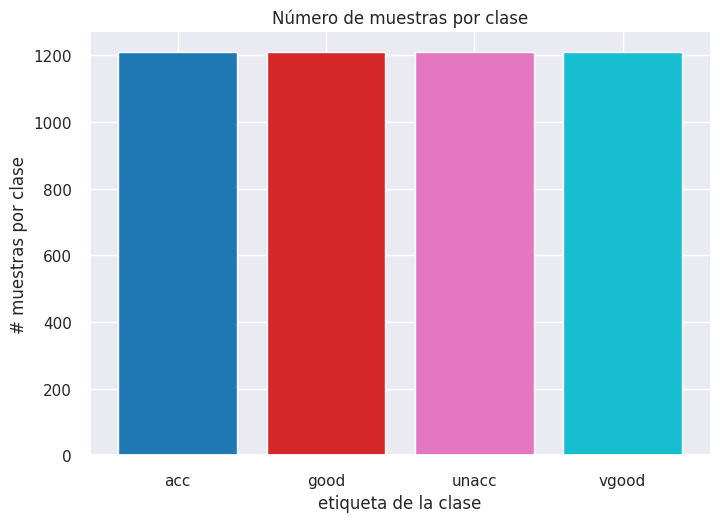

In [17]:
mostrarGrafica(y_car_smote)

In [18]:
X_car_smote

,buying,maint,doors,persons,lug_boot,safety
0,3,3,0,0,2,1
1,3,3,0,0,2,2
2,3,3,0,0,2,0
3,3,3,0,0,1,1
4,3,3,0,0,1,2
...,...,...,...,...,...,...
4835,2,1,1,2,1,0
4836,1,1,0,1,0,0
4837,1,0,3,1,1,0
4838,1,2,0,1,0,0


## Elección de los mejores modelos y métricas

Gracias a la librería "pycaret" se realizó la evaluación de diferentes modelos junto con diferentes métricas, con el fin de determinar cuáles podrían tener mejor rendimiento y se podría implementar en este contexto de la evaluación de carros.

In [ ]:
!pip install pycaret

In [20]:
from pycaret.classification import *

**Merjores modelos y métricas para el dataset desbalanceado**

In [21]:
model_setup = setup(data=df_car, target='class', session_id=123)

,Description,Value
0,Session id,123
1,Target,class
2,Target type,Multiclass
3,Target mapping,"acc: 0, good: 1, unacc: 2, vgood: 3"
4,Original data shape,"(1728, 7)"
5,Transformed data shape,"(1728, 7)"
6,Transformed train set shape,"(1209, 7)"
7,Transformed test set shape,"(519, 7)"
8,Numeric features,6
9,Preprocess,True


In [22]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9909,0.0000,0.9909,0.9917,0.9910,0.9802,0.9803,1.4930
xgboost,Extreme Gradient Boosting,0.9859,0.0000,0.9859,0.9872,0.9859,0.9694,0.9697,0.1430
gbc,Gradient Boosting Classifier,0.9826,0.0000,0.9826,0.9837,0.9826,0.9623,0.9626,0.5110
dt,Decision Tree Classifier,0.9752,0.0000,0.9752,0.9773,0.9752,0.9458,0.9463,0.0480
rf,Random Forest Classifier,0.9702,0.0000,0.9702,0.9714,0.9695,0.9343,0.9350,0.2500
et,Extra Trees Classifier,0.9611,0.0000,0.9611,0.9634,0.9598,0.9145,0.9152,0.1830
knn,K Neighbors Classifier,0.9082,0.0000,0.9082,0.9115,0.9003,0.7868,0.7920,0.0500
ada,Ada Boost Classifier,0.7577,0.0000,0.7577,0.7607,0.7538,0.4749,0.4794,0.1650
ridge,Ridge Classifier,0.7006,0.0000,0.7006,0.5948,0.6277,0.1247,0.1522,0.0400
dummy,Dummy Classifier,0.7006,0.0000,0.7006,0.4908,0.5772,0.0000,0.0000,0.0330


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Para el caso del dataset **desbalanceado**, se puede observar que varios modelos presentan muy buenos resultados. Sin embargo, algunos modelos presentan resultados bastante deficientes por lo que quedan descartados para implementarse en este problema.

Los valores en "0" de la métrica AUC (Área Bajo la Curva) pueden ocurrir debido a que se está evaluando como un problema biclass cuando en realidad se trata de un contexto multiclass.

**Merjores modelos y métricas para el dataset balanceado**

In [ ]:
model_setup_smote = setup(data=pd.concat([X_car_smote, y_car_smote], axis=1), target='class', session_id=123)

,Description,Value
0,Session id,123
1,Target,class
2,Target type,Multiclass
3,Target mapping,"acc: 0, good: 1, unacc: 2, vgood: 3"
4,Original data shape,"(4840, 7)"
5,Transformed data shape,"(4840, 7)"
6,Transformed train set shape,"(3388, 7)"
7,Transformed test set shape,"(1452, 7)"
8,Numeric features,6
9,Preprocess,True


In [ ]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9965,0.0000,0.9965,0.9965,0.9965,0.9953,0.9953,0.9760
xgboost,Extreme Gradient Boosting,0.9962,0.0000,0.9962,0.9962,0.9962,0.9949,0.9949,0.3030
dt,Decision Tree Classifier,0.9917,0.0000,0.9917,0.9918,0.9917,0.9890,0.9890,0.0390
et,Extra Trees Classifier,0.9914,0.0000,0.9914,0.9917,0.9914,0.9886,0.9887,0.2380
rf,Random Forest Classifier,0.9894,0.0000,0.9894,0.9897,0.9894,0.9858,0.9859,0.2800
gbc,Gradient Boosting Classifier,0.9826,0.0000,0.9826,0.9831,0.9826,0.9768,0.9770,0.8790
knn,K Neighbors Classifier,0.8810,0.0000,0.8810,0.8887,0.8772,0.8414,0.8456,0.0650
ada,Ada Boost Classifier,0.7948,0.0000,0.7948,0.8109,0.7808,0.7264,0.7375,0.1870
nb,Naive Bayes,0.5965,0.0000,0.5965,0.6872,0.5861,0.4620,0.5035,0.0410
lda,Linear Discriminant Analysis,0.5629,0.0000,0.5629,0.5295,0.5386,0.4172,0.4216,0.0430


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Para el caso del dataset **balanceado**, se puede observar que la eficiencia mejora en algunos modelos en comparación con los resultados obtenidos en el dataset desbalanceado. Sin embargo, a pesar de esta mejora aún hay modelos con una eficiencia bastante mala por lo que quedan descartados.

Los valores en "0" de la métrica AUC (Área Bajo la Curva) pueden ocurrir debido a que se está evaluando como un problema biclass cuando en realidad se trata de un contexto multiclass.

**Conclusión:**
Para la elección de los tres modelos a implementar, se tomaron aquellos que presentaran una mejor eficiencia o valores más altos en sus métricas en ambos dataset.

Dicho esto, se tenían varios modelos que cumplieran estos requisitos pero se decidió por los tres más comunes en cuanto a nuestra investigación:

*   Decision Tree Classifier
*   Random Forest Classifier
*   Extreme Gradient Boosting



## Descarga del dataset

In [ ]:
def descargarDataframe(X, y, nombre):
  df = pd.concat([X, y], axis=1)
  df.to_csv(nombre+'.csv', index=False)
  files.download(nombre+'.csv')

In [ ]:
descargarDataframe(X=X_car_smote, y=y_car_smote, nombre='car_evaluation_smote')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>